### Required library installations

In [64]:
!pip install scikit-learn
!pip install avro
!pip install torch
!pip install matplotlib

### Uploading file to Google Colab

In [ ]:
from google.colab import files
uploaded = files.upload()

### Load data from avro file

In [15]:
import pandas as pd
from avro.datafile import DataFileReader
from avro.io import DatumReader

# Change the path to locate the avro file; In case of Google Colab use the file name.
filename_txt = 'trial_small.avro'
avro_records = []
with open(filename_txt, 'rb') as f:
    reader = DataFileReader(f, DatumReader())
    avro_records = [rec for rec in reader]
    reader.close()

dataset = pd.DataFrame(avro_records)

In [16]:
dataset['cnf'] = dataset['cnf'].astype('string')
dataset['label'] = dataset['label'].astype('int')
print('Total: ', dataset.shape)

Total:  (5921, 2)


In [17]:
from sklearn.utils import shuffle   
dataset = shuffle(dataset)
dataset.reset_index(inplace=True, drop=True)

In [18]:
print("Unsat Shape:", dataset[dataset.label == 0].shape)
print("Sat Shape:", dataset[dataset.label == 1].shape)

Unsat Shape: (2761, 2)
Sat Shape: (3160, 2)


In [19]:
dataset.head()

,cnf,label
0,( 16 V -17 V 7 ) ^ ( -12 V -5 V 19 ) ^ ( 18 V ...,1
1,( -48 V -40 V -21 ) ^ ( 4 V 29 V 15 ) ^ ( -40 ...,0
2,( -51 V 91 V -17 ) ^ ( -81 V 114 V 95 ) ^ ( -1...,0
3,( 15 V -44 V 46 ) ^ ( -90 V 66 V 62 ) ^ ( 77 V...,0
4,( 70 V -1 V -45 ) ^ ( -74 V -34 V 99 ) ^ ( -19...,0


In [20]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dataset, test_size=0.1)
test_df.reset_index(drop=True, inplace=True)

print("Rows in test: %s " % len(test_df))
print("Rows in train: %s " % len(train_df))

Rows in test: 593 
Rows in train: 5328 


In [21]:
train_df.head(5)

,cnf,label
4884,( 82 V 20 V 40 ) ^ ( -122 V 5 V 79 ) ^ ( 75 V ...,0
266,( -35 V 34 V 14 ) ^ ( -5 V -6 V 17 ) ^ ( 44 V ...,1
822,( -62 V 46 V 1 ) ^ ( 12 V -68 V -55 ) ^ ( -28 ...,1
4815,( 40 V -2 V -4 ) ^ ( -13 V 48 V 17 ) ^ ( 17 V ...,0
1538,( 32 V -26 V -14 ) ^ ( 27 V 67 V -9 ) ^ ( 86 V...,1


# Imports

In [23]:
import torch
import torch.nn as nn
import math
import random
import time
import matplotlib.pyplot as plt

%matplotlib inline

# Preparing Data

In [24]:
# Generate a list of tuples (title, label) for each data row
def read_data(dataframe):
    df = dataframe[['cnf', 'label']]
    df = df.dropna(subset=['cnf', 'label'])
    return [tuple(x) for x in df.to_numpy()]

#Get a random tuple from the list of pairs
def random_training_pair(pairs):
    rand_index = random.randint(0, len(pairs) - 1)
    return pairs[rand_index]

# Establish Tensors

In [25]:
all_characters = '()0123456789-V^'
n_characters = len(all_characters)

In [46]:
# Turns line into <line_length x 1 x n_letters> tensor
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_characters)
    for li, letter in enumerate(line):
        tensor[li][0][all_characters.find(letter)] = 1
    return tensor

# Turns label into <1 x 1> tensor
def label_to_tensor(label):
    return torch.tensor([label], dtype=torch.long)

# Takes the category with the highest probability as a guess
def category_from_output(output):
    top_n, top_i = output.topk(1)
    return top_i[0].item()

# Create Network

In [47]:
class RNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassify, self).__init__()

        self.hidden_size = hidden_size
        
        # Initialize linear and sigmoid layers
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.sigmoid = nn.LogSigmoid()

    def forward(self, input, hidden=None):
        # Concatenate input tensor and hidden state
        combined = torch.cat((input, hidden), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.sigmoid(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


# Train Network

In [41]:
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

Epoch: 1 - 100 20% (1m 24s) 0.6925
Epoch: 1 - 200 40% (3m 11s) 0.6752
Epoch: 1 - 300 60% (4m 57s) 0.6740
Epoch: 1 - 400 80% (6m 40s) 0.7252
Epoch: 1 - 500 100% (8m 19s) 0.6417
Epoch: 2 - 100 20% (9m 56s) 0.7068
Epoch: 2 - 200 40% (11m 26s) 0.6231
Epoch: 2 - 300 60% (13m 13s) 0.6828
Epoch: 2 - 400 80% (15m 6s) 0.6862
Epoch: 2 - 500 100% (16m 39s) 0.6083
Epoch: 3 - 100 20% (18m 20s) 0.6596
Epoch: 3 - 200 40% (20m 3s) 0.6556
Epoch: 3 - 300 60% (21m 54s) 0.6352
Epoch: 3 - 400 80% (23m 47s) 0.5961
Epoch: 3 - 500 100% (25m 29s) 0.5549
Epoch: 4 - 100 20% (27m 15s) 0.5672
Epoch: 4 - 200 40% (28m 49s) 0.6371
Epoch: 4 - 300 60% (30m 28s) 0.5389
Epoch: 4 - 400 80% (32m 25s) 0.6325
Epoch: 4 - 500 100% (34m 3s) 0.6102
Epoch: 5 - 100 20% (35m 45s) 0.6068
Epoch: 5 - 200 40% (37m 25s) 0.6102
Epoch: 5 - 300 60% (38m 56s) 0.6053
Epoch: 5 - 400 80% (40m 34s) 0.5936
Epoch: 5 - 500 100% (42m 0s) 0.6000
Epoch: 6 - 100 20% (43m 35s) 0.5338
Epoch: 6 - 200 40% (45m 21s) 0.5827
Epoch: 6 - 300 60% (46m 53s) 0.51

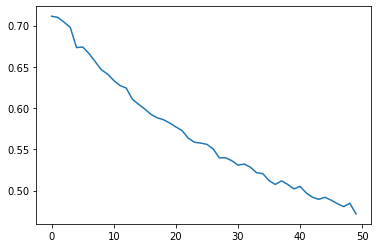

In [48]:
# Helper function to display how long the training has been running
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


# Creates function that performs a step in the training loop
def make_train_step(model, criterion, optimizer):
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Initialize hidden state
        hidden = model.init_hidden()

        # Makes predictions, running through each letter tensor
        for i in range(x.size()[0]):
            output, hidden = model(x[i], hidden)

        # Computes loss
        loss = criterion(output, y)

        # Computes gradients
        loss.backward()

        # Updates parameters
        optimizer.step()
        optimizer.zero_grad()

        return output, loss.item()

    return train_step

# Run training on a given dataframe
def run(train_df, plot=False):
    n_iters = 500
    n_epochs = 10
    print_every = 100
    plot_every = 100
    hidden_len = 64

    current_loss = 0
    all_losses = []

    model = RNNClassify(n_characters, hidden_len, 2)
    data_tuples = read_data(train_df)

    # Create the optimizer and loss function (criterion)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
    criterion = nn.NLLLoss()

    
    train_step = make_train_step(model, criterion, optimizer)
    scheduler1 = ExponentialLR(optimizer, gamma=0.9)
    scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

    start = time.time()
    for iter in range(1, n_epochs + 1):
        for i in range(1, n_iters + 1):
            # Get data and turn input/target into tensors
            title, label = random_training_pair(data_tuples)
            input_tensor = line_to_tensor(title)
            target_tensor = label_to_tensor(label)

            # Run one training step
            output, loss = train_step(input_tensor, target_tensor)

            # The rest of the code in this function is to show how
            # the network is learning
            current_loss += loss

            if i % print_every == 0:
                print('Epoch: %d - %d %d%% (%s) %.4f' % (iter, i, i / n_iters * 100, time_since(start), loss))
            
            if i % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0
        
        scheduler1.step()
        scheduler2.step()

    if plot:
        plt.figure()
        plt.xlabel("Loss Value")
        plt.ylabel("Iterations (scale = 100)")
        plt.plot(all_losses)

    # Save the model
    torch.save(model.state_dict(), "test.model")

run(train_df, plot=True)

# Evaluate Model

In [52]:
# Predict the label given a cnf
def evaluate(cnf, model):
    model.eval()
    hidden = model.init_hidden()
    input_tensor = line_to_tensor(cnf)
    for i in range(input_tensor.size()[0]):
        output, hidden = model(input_tensor[i], hidden)
    return category_from_output(output)

# Calculate accuracy, recall, and precision on a given test dataframe
def calculate_accuracy(model, test_df):
    false_positives = 0
    false_negatives = 0
    true_positives = 0
    true_negatives = 0

    tuples = read_data(test_df)
    for cnf, label in tuples:
        prediction = evaluate(cnf, model)
        if label == prediction and label:
            true_positives += 1
        if label == prediction and not label:
            true_negatives += 1
        if label != prediction and label:
            false_negatives += 1
        if label != prediction and not label:
            false_positives += 1
    accuracy = (true_positives + true_negatives) / len(test_df)
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)

    return accuracy, recall, precision

In [54]:
model = RNNClassify(n_characters, 64, 2)
model.load_state_dict(torch.load('test.model'))
accuracy, recall, precision = calculate_accuracy(model, test_df)

In [62]:
print('Accuracy:', str(round(accuracy, 4)*100), '\nRecall:', str(round(recall, 2)), '\nPrecision:', str(round(precision, 2)))

Accuracy: 54.620000000000005 
Recall: 0.96 
Precision: 0.51
